In [1]:
import pandas as pd

In [3]:
alldf = pd.read_csv('../data/all.csv')
alldf

,equipmentId,dateTime,load,hotspotTemperature,nominalLoad,locationId,coolingType,manufactureYear,commissioningDate,enclosure,...,heatRunTest_ambiantTemperature,heatRunTest_deltaTopOil,heatRunTest_deltaHotspot,heatRunTest_x,heatRunTest_y,heatRunTest_h,heatRunTest_gradient,temperature,windSpeed,relativeHumidityPercentage
0,50033827,2023-04-30 22:00:00,12294.37,41.02,40.0,2,ONAF1,2008,2010-03-17,1 wall,...,25.4,54.1,67.4,0.73,1.48,1.13,11.8,13.9200,2.430,62.840
1,50033827,2023-04-30 22:15:00,12115.62,41.38,40.0,2,ONAF1,2008,2010-03-17,1 wall,...,25.4,54.1,67.4,0.73,1.48,1.13,11.8,13.8550,2.395,62.845
2,50033827,2023-04-30 22:30:00,11374.81,41.38,40.0,2,ONAF1,2008,2010-03-17,1 wall,...,25.4,54.1,67.4,0.73,1.48,1.13,11.8,13.7900,2.360,62.850
3,50033827,2023-04-30 22:45:00,10417.08,40.78,40.0,2,ONAF1,2008,2010-03-17,1 wall,...,25.4,54.1,67.4,0.73,1.48,1.13,11.8,13.7250,2.325,62.855
4,50033827,2023-04-30 23:00:00,10130.00,40.50,40.0,2,ONAF1,2008,2010-03-17,1 wall,...,25.4,54.1,67.4,0.73,1.48,1.13,11.8,13.6600,2.290,62.860
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1093503,50249457,2025-02-28 21:45:00,12099.23,NaN,25.0,2,ONAF1,2011,2016-04-15,4 walls,...,23.0,51.9,67.7,0.66,1.34,1.10,14.4,3.2675,2.685,87.400
1093504,50249457,2025-02-28 22:00:00,11592.00,NaN,25.0,2,ONAF1,2011,2016-04-15,4 walls,...,23.0,51.9,67.7,0.66,1.34,1.10,14.4,3.0600,2.730,88.510
1093505,50249457,2025-02-28 22:15:00,11320.73,NaN,25.0,2,ONAF1,2011,2016-04-15,4 walls,...,23.0,51.9,67.7,0.66,1.34,1.10,14.4,NaN,NaN,NaN
1093506,50249457,2025-02-28 22:30:00,11050.42,NaN,25.0,2,ONAF1,2011,2016-04-15,4 walls,...,23.0,51.9,67.7,0.66,1.34,1.10,14.4,NaN,NaN,NaN


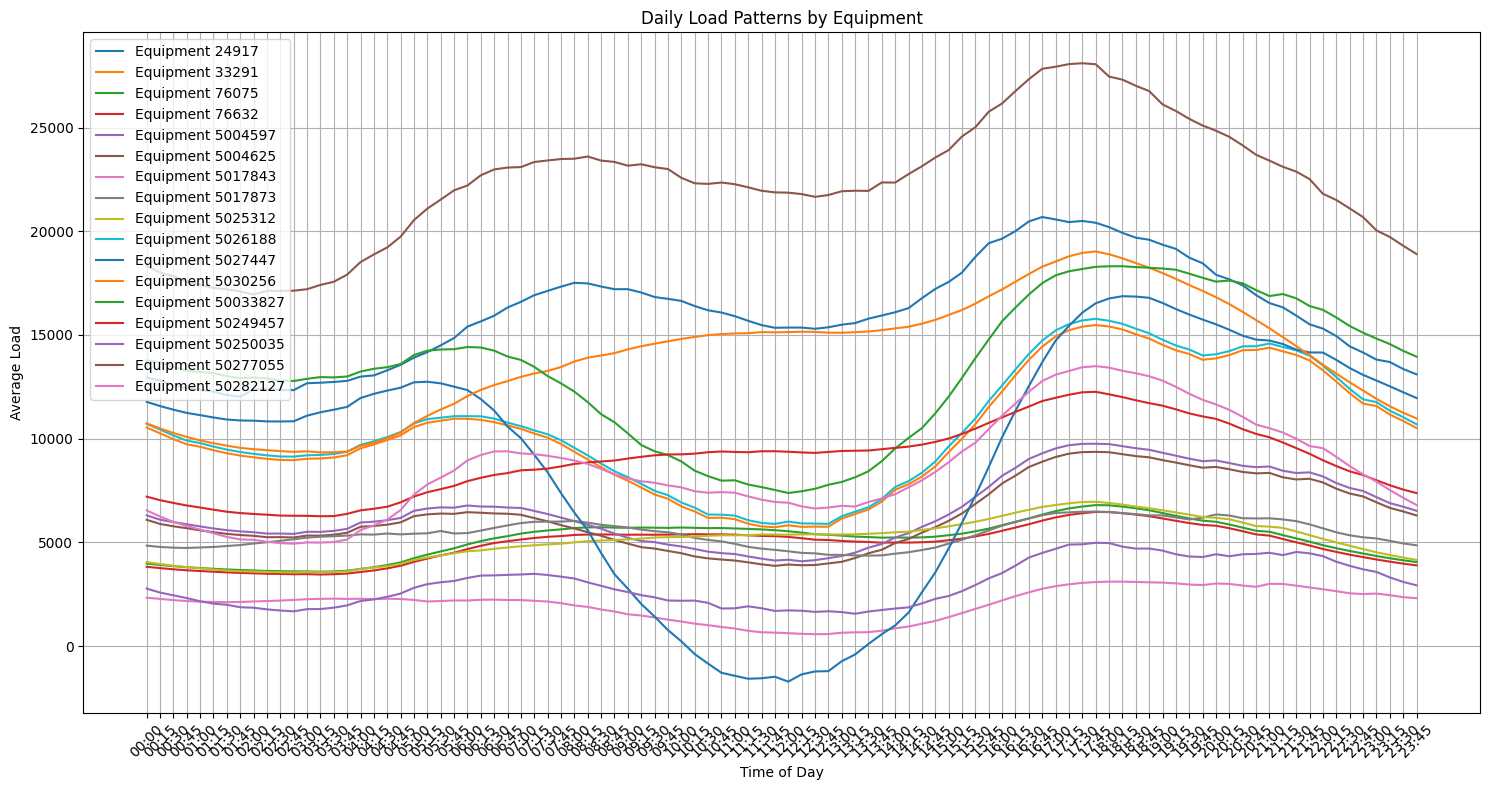

In [4]:
import seaborn as sns
from datetime import datetime

import matplotlib.pyplot as plt

# Convert dateTime to datetime
alldf['dateTime'] = pd.to_datetime(alldf['dateTime'])

# Extract hour and minute
alldf['time_of_day'] = alldf['dateTime'].dt.strftime('%H:%M')

# Group by equipmentId and time_of_day to get mean load
daily_patterns = alldf.groupby(['equipmentId', 'time_of_day'])['load'].agg(['mean', 'std']).reset_index()

# Plot for each equipment
plt.figure(figsize=(15, 8))
for equipment in daily_patterns['equipmentId'].unique():
    equipment_data = daily_patterns[daily_patterns['equipmentId'] == equipment]
    plt.plot(equipment_data['time_of_day'], equipment_data['mean'], label=f'Equipment {equipment}')
    
plt.xticks(rotation=45)
plt.xlabel('Time of Day')
plt.ylabel('Average Load')
plt.title('Daily Load Patterns by Equipment')
plt.legend()
plt.grid(True)
plt.tight_layout()

In [10]:
import numpy as np
from scipy.fft import fft
from scipy.optimize import minimize

# Function to create normalized 24-hour profile from the data
def create_24h_profile(df, equipment_id):
    equipment_data = df[df['equipmentId'] == equipment_id].copy()
    equipment_data['hour'] = pd.to_datetime(equipment_data['time_of_day']).dt.hour + pd.to_datetime(equipment_data['time_of_day']).dt.minute/60
    hourly_load = equipment_data.groupby('hour')['load'].mean()
    # Normalize the load
    normalized_load = (hourly_load - hourly_load.min()) / (hourly_load.max() - hourly_load.min())
    return normalized_load

# Function to create industrial and residential load patterns
def create_reference_patterns(hours):
    industrial = 0.6 * np.sin((2 * np.pi / 24) * (hours - 6)) + 0.7  # Peak around noon
    residential = 0.4 * np.sin((2 * np.pi / 24) * (hours - 18)) + 0.5  # Peak around 8PM
    return industrial, residential

# Function to fit the combination of patterns
def fit_patterns(actual_load, industrial, residential, x0=[0.5, 0.5]):
    def objective(weights):
        return np.sum((actual_load - (weights[0]*industrial + weights[1]*residential))**2)
    
    # Constraints: weights sum to 1 and are non-negative
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1},)
    bounds = [(0, 1), (0, 1)]
    
    result = minimize(objective, x0, constraints=constraints, bounds=bounds)
    return result.x

# Analyze each equipment
unique_equipment = alldf['equipmentId'].unique()
results = {}

for equipment_id in unique_equipment:
    # Create 24-hour profile
    load_profile = create_24h_profile(alldf, equipment_id)
    
    # Create reference patterns
    hours = load_profile.index.values
    industrial_pattern, residential_pattern = create_reference_patterns(hours)
    # Normalize patterns between 0 and 1
    industrial_pattern = (industrial_pattern - industrial_pattern.min()) / (industrial_pattern.max() - industrial_pattern.min())
    residential_pattern = (residential_pattern - residential_pattern.min()) / (residential_pattern.max() - residential_pattern.min())
    
    # Fit patterns
    weights = fit_patterns(load_profile.values, industrial_pattern, residential_pattern)
    
    results[equipment_id] = {
        'industrial_percentage': weights[0] * 100,
        'residential_percentage': weights[1] * 100
    }

# Display results
results_df = pd.DataFrame.from_dict(results, orient='index')
print("Load Pattern Analysis Results:")
print(results_df)

/var/folders/n9/q8bvx5ln4m10k1kwfc2w0zd40000gn/T/ipykernel_21451/3754848727.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  equipment_data['hour'] = pd.to_datetime(equipment_data['time_of_day']).dt.hour + pd.to_datetime(equipment_data['time_of_day']).dt.minute/60
/var/folders/n9/q8bvx5ln4m10k1kwfc2w0zd40000gn/T/ipykernel_21451/3754848727.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  equipment_data['hour'] = pd.to_datetime(equipment_data['time_of_day']).dt.hour + pd.to_datetime(equipment_data['time_of_day']).dt.minute/60
/var/folders/n9/q8bvx5ln4m10k1kwfc2w0zd40000gn/T/ipykernel_21451/3754848727.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dat

Load Pattern Analysis Results:
          industrial_percentage  residential_percentage
50033827              23.665903               76.334097
50282127              54.283762               45.716238
50277055              67.964855               32.035145
5004625               32.232064               67.767936
5004597               33.478841               66.521159
24917                 69.227701               30.772299
33291                 28.191608               71.808392
5026188               28.459895               71.540105
5017873               42.877230               57.122770
5017843               19.034067               80.965933
76075                 73.566367               26.433633
76632                 72.567939               27.432061
5025312               68.408013               31.591987
5030256               71.956609               28.043391
50250035              36.762952               63.237048
5027447               14.786300               85.213700
50249457         

/var/folders/n9/q8bvx5ln4m10k1kwfc2w0zd40000gn/T/ipykernel_21451/3754848727.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  equipment_data['hour'] = pd.to_datetime(equipment_data['time_of_day']).dt.hour + pd.to_datetime(equipment_data['time_of_day']).dt.minute/60
/var/folders/n9/q8bvx5ln4m10k1kwfc2w0zd40000gn/T/ipykernel_21451/3754848727.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  equipment_data['hour'] = pd.to_datetime(equipment_data['time_of_day']).dt.hour + pd.to_datetime(equipment_data['time_of_day']).dt.minute/60


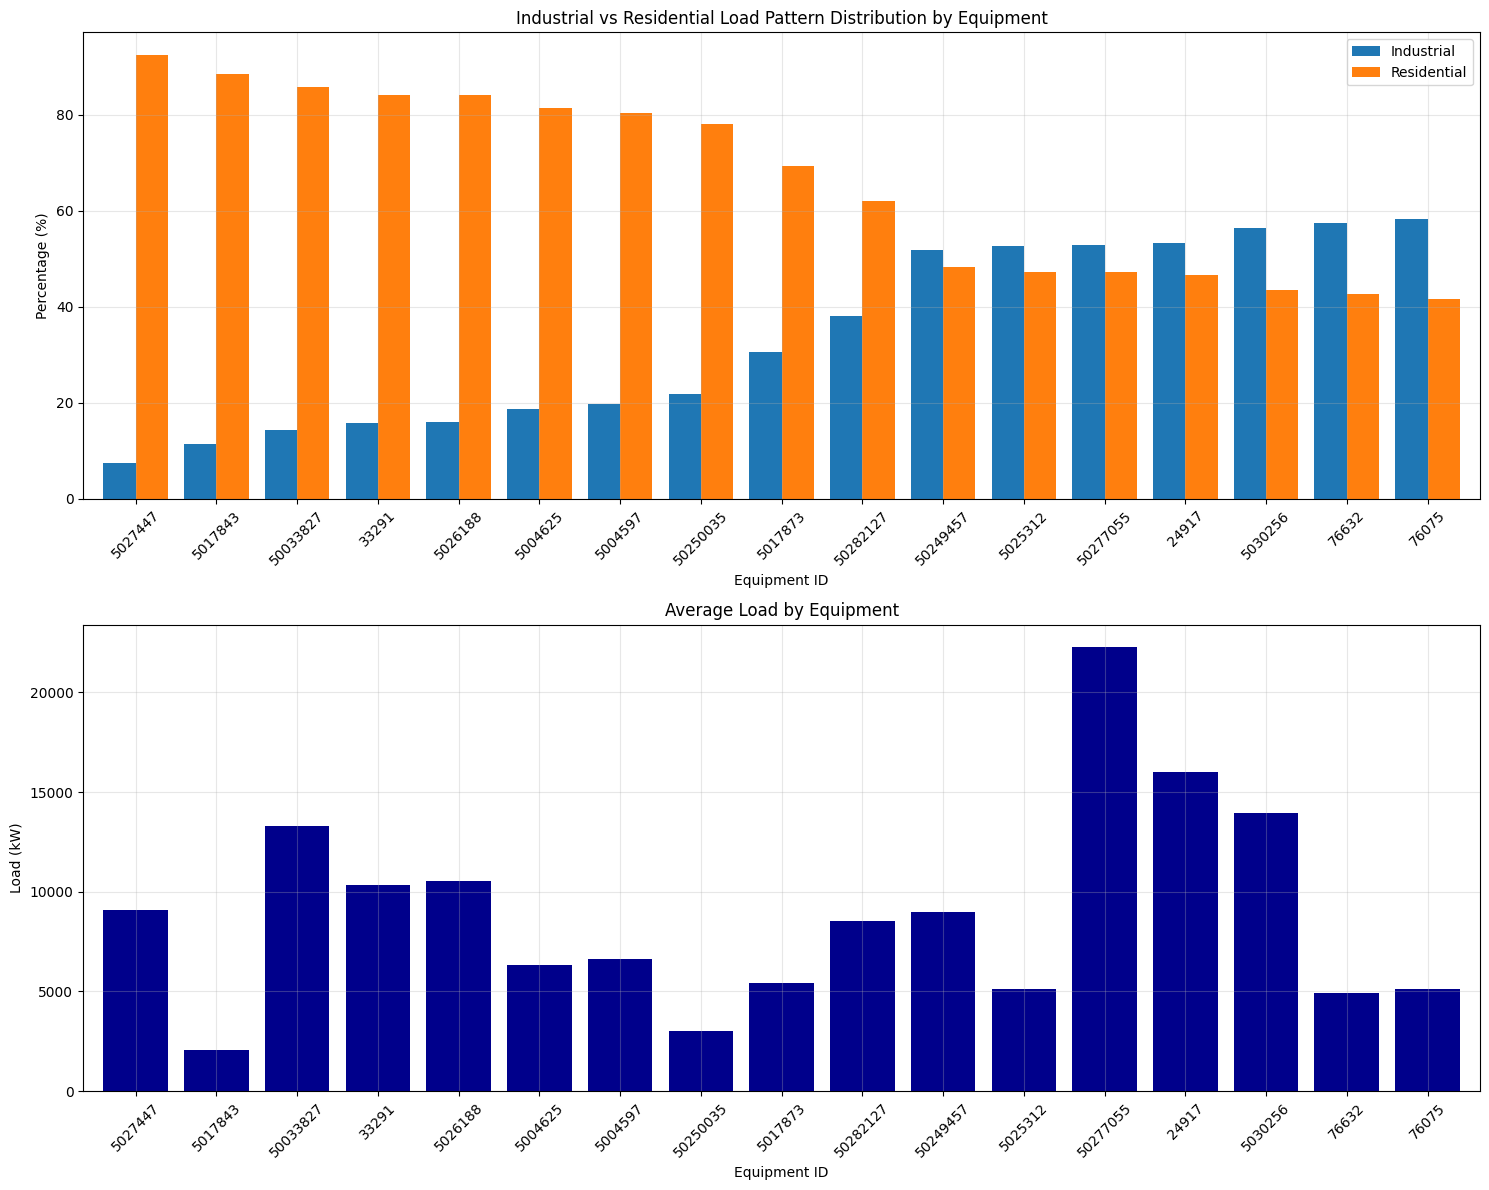

In [9]:
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

# Sort results by industrial percentage for better visualization
results_df_sorted = results_df.sort_values('industrial_percentage', ascending=True)

# Plot industrial vs residential percentages with better formatting
results_df_sorted.plot(kind='bar', ax=ax1, width=0.8)
ax1.set_title('Industrial vs Residential Load Pattern Distribution by Equipment', fontsize=12)
ax1.set_xlabel('Equipment ID', fontsize=10)
ax1.set_ylabel('Percentage (%)', fontsize=10)
ax1.legend(['Industrial', 'Residential'])
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='x', rotation=45)

# Plot average loads with matching order of equipment IDs
equipment_loads_sorted = equipment_loads.reindex(results_df_sorted.index)
equipment_loads_sorted.plot(kind='bar', ax=ax2, color='darkblue', width=0.8)
ax2.set_title('Average Load by Equipment', fontsize=12)
ax2.set_ylabel('Load (kW)', fontsize=10)
ax2.set_xlabel('Equipment ID', fontsize=10)
ax2.grid(True, alpha=0.3)
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()